# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Данные предобработанны в SQL и теперь они готовы для проверки гипотезы в Python. Загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. 

Проверим наличие дубликатов в идентификаторах пользователей. Сравним размеры групп, их статистики и распределение.

Проверим гипотезу: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.


- Автор: Владимир Добров
- Дата: 12.07.2025

## Цели и задачи проекта

- Проверка гипотезы о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

## Описание данных

Таблицы содержат данные о чтении и прослушивании контента в сервисе Яндекс Книги, которые включают информацию о пользователях, платформах, времени, длительности сессий и типах контента. Данные представлены за период с 1 сентября по 11 декабря 2024 года. 

Таблица bookmate.audition содержит данные об активности пользователей и состоит из следующих полей:  
- audition_id — уникальный идентификатор сессии чтения или прослушивания;    
- puid — идентификатор пользователя;  
- usage_platform_ru — название платформы, с помощью которой пользователь слушал контент;  
- msk_business_dt_str — дата события в формате строки (московское время);  
- app_version — версия приложения, которая использовалась для чтения или прослушивания;  
- adult_content_flg — был ли это контент для взрослых: True или False;
- hours — длительность чтения или прослушивания в часах;
- hours_sessions_long — продолжительность длинных сессий чтения или прослушивания в часах;
- kids_content_flg — был ли это детский контент: True или False;
- main_content_id — идентификатор основного контента;
- usage_geo_id — идентификатор географического местоположения.  
---
Таблица bookmate.content содержит данные о контенте и состоит из следующих полей:  
- main_content_id — идентификатор основного контента;
- main_author_id — идентификатор основного автора контента;
- main_content_type — тип контента;
- main_content_name— название контента;
- main_content_duration_hours — длительность контента в часах;
- published_topic_title_list — список жанров контента.  
---
Таблица bookmate.author содержит данные об авторах контента и состоит из следующих полей:  
- main_author_id — идентификатор основного автора контента;
- main_author_name — имя основного автора контента.  
---
Таблица bookmate.geo содержит данные о местоположении и состоит из следующих полей:  
- usage_geo_id — идентификатор географического положения;
- usage_geo_id_name — город или регион географического положения;
- usage_country_name — страна географического положения.

## Содержимое проекта

---

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

## 1. Загрузка данных и знакомство с ними


In [1]:
# Импортируем библиотеки
import pandas as pd

import numpy as np

from scipy.stats import ttest_ind

from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

# Импортируем библиотеки для визуализации данных
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2


- Загрузим данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания)

In [2]:
# Выгружаем и сохраняем в датафрейм данные 
yandex_knigi_data = pd.read_csv('/datasets/yandex_knigi_data.csv')
# Убираем столбец без названия
yandex_knigi_data = yandex_knigi_data.drop(['Unnamed: 0'], axis=1)

display(yandex_knigi_data.head(5))

# Проверим наличие дубликатов puid
dubl_puid = yandex_knigi_data['puid'].duplicated().sum()
print(f'Количество дубликатов: {dubl_puid}')

# Характер дубликата
print('Причина - один пользователь бывает в Москве и Санкт-Петербурге')
print(yandex_knigi_data[yandex_knigi_data['puid']==2637041])
# knigi_data[knigi_data.duplicated('puid')].sort_values(by='puid')
print()
# Количество пользователей в группах по городаv
mos_count = len(yandex_knigi_data[yandex_knigi_data['city']=='Москва'])
print(f'Количество puid Москвы: {mos_count}')
spb_count = len(yandex_knigi_data[yandex_knigi_data['city']=='Санкт-Петербург'])
print(f'Количество puid Санкт-Петербург: {spb_count}')      

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


Количество дубликатов: 244
Причина - один пользователь бывает в Москве и Санкт-Петербурге
                 city     puid      hours
35             Москва  2637041  10.317371
6247  Санкт-Петербург  2637041   3.883926

Количество puid Москвы: 6234
Количество puid Санкт-Петербург: 2550


In [3]:
# Удаляем все дубликаты
knigi_data = yandex_knigi_data.drop_duplicates(subset=['puid'], keep=False)
dubl = knigi_data['puid'].duplicated().sum()
print(f'Количество дубликатов: {dubl}')

Количество дубликатов: 0


Выводы:
- количество пользователей Москвы (6234) существенно больше количества пользователей Санкт-Петербурга (2550)
- есть 244 пересечения групп. Один пользователь бывает в обоих городах. Для независимости выборок эти данные удалены  
- Вывод:  
Так как группы выборок Москва и Санкт-Петербург статистически существенно различаются, то применим t-тест Уэлча, который не требует равенства и однородности выборок и работает с неоднородными.

In [4]:
# Разделим данные датафрейма на две группы целевых метрик по городам
mos_kniga = knigi_data[knigi_data['city']=='Москва']['hours']
spb_kniga = knigi_data[knigi_data['city']=='Санкт-Петербург']['hours']

# Определим уровень значимости 
alpha = 0.05 

# Применяем тест Стьюдента
stat_ttest, p_value_ttest = ttest_ind(
    mos_kniga, 
    spb_kniga,
    equal_var = False)
#     alternative='less') # альтернативная гипотеза: средняя активность в Москве меньше чем в Санкт-Петербурге

if p_value_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_ttest, 2)}')
    print('H₀ (нулевая гипотеза) — Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.')
else:
    print(f'p-value теста Уэлча ={round(p_value_ttest, 2)}')
    print('H₁ (альтернативная гипотеза) — Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.')


p-value теста Уэлча =0.66
H₀ (нулевая гипотеза) — Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


## 3. Аналитическая записка

- У жителей этих городов схожий образ жизни и бытовые привычки и это помогает логично объяснить результаты
- Для проверки гипотезы о различии средней активности пользователей Москвы и Санкт-Петербурга был выбран t-test Уэлча  
- в результате теста получено p-value = 0.66
- Интерпретация: H₀ (нулевая гипотеза) подтверждена — Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается
- Причины такого результата: выборочные средние значение активности в Москве и Санкт-Петербурге статистически равны, p-value 0.66 > 0.05 уровня значимости

----

# Часть 2. Анализ результатов A/B-тестирования

К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача — провести оценку результатов A/B-теста. В нашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Необходимо оценить корректность проведения теста и проанализировать его результаты.

## 1. Цели исследования.



Цель исследования - проверить гипотизу о том, что разработка новой версии сайта помогает привлечь новых клиентов и увеличить число продаж.

## 2. Загрузка данных, оценка их целостности.


In [5]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [6]:
print('-- participants')
participants.info()
print('-- events')
events.info()

-- participants
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB
-- events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [7]:
display(participants.head())
events.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [8]:
# Найдём количество пропусков данных
print(f'participants :\n{participants.isna().sum()}\n')
print(f'events :\n{events.isna().sum()}')

participants :
user_id    0
group      0
ab_test    0
device     0
dtype: int64

events :
user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64


In [9]:
# Посмотрим на пользователей GLOBAL
events.groupby(['user_id', 'event_name']).agg({'event_name': 'count'}).query('user_id == "GLOBAL"')

event_name
user_id event_name                                    
GLOBAL  End of Black Friday Ads Campaign             1
        Start of CIS New Year Gift Lottery           1
        Start of Christmas&New Year Promo            1
        product_cart                              9806
        product_page                             33166
        purchase                                 15520

Выводы:  
- пропуски в поле с доп.данными о событиях показыват активность пользователей не связанную с оплатой услуг. По этому не повлияют на результат.
- user_id == 'GLOBAL' обозначают незарегистрированных пользователей

## 3. По таблице `ab_test_participants` оцениим корректность проведения теста:

   ### 3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

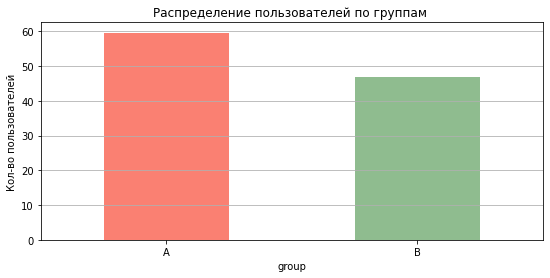

group
A    59.61
B    46.89
Name: user_id, dtype: float64


In [10]:
# Определим долю пользователей по группам А/В
gr_test = round(participants.groupby('group')['user_id'].count() / participants['user_id'].nunique() * 100, 2)

# Строим диаграмму распределения пользователей по группа А/В
gr_test.plot(kind='bar',
                  rot=0,
                  color=['salmon', 'darkseagreen'],
                  figsize=(9, 4))
            
# Настраиваем оформление графика
plt.title("Распределение пользователей по группам ")
plt.ylabel('Кол-во пользователей')
plt.grid(axis='y')
# Отображаем график
plt.show() 

print(gr_test)

Вывод:
- Доля пользователей группы А (59.61%) на 13% превышает количество пользователей группы В (46.89%), что может повлиять на результат исследования

In [11]:
# Пользователи группы А
users_a = participants[participants['group']=='A']['user_id']
# Пользователи группы В
users_b = participants[participants['group']=='B']['user_id']

# Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B
interselection = len(list(set(users_a) & set(users_b)))
print(f'Кол-во пользователей, которые встречаются одновременно в группах A и B: {interselection}')

Кол-во пользователей, которые встречаются одновременно в группах A и B: 446


Выводы:
- присутствуют пересечения с конкурирующим тестом (446) пользователей, участвующих одновременно в двух тестовых группах) 
- доля пересечения порядка 3% от общего количества не повлияет существенным образом на результат тестирования. Риск ошибочной интерпретации результатов изменений не высок.


### 3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями

In [12]:
# Определим только события, связанные с участвующими в изучаемом тесте пользователями
events_test = participants.merge(events, on='user_id', how='left')
events_test

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN
...,...,...,...,...,...,...,...
104553,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-24 00:56:12,product_cart,NaN
104554,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-24 00:57:23,product_cart,NaN
104555,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45
104556,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN


- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [13]:
# Определим даты регистрации пользователей
event_reg = events_test[events_test['event_name'] == 'registration'][['user_id', 'event_dt']].rename(columns={'event_dt': 'event_dt_reg'})
event_reg
# Свяжем с исходной таблицей и добавим колонку с датой регистрации 
event_0 = events_test.merge(event_reg, on='user_id', how='left')
# Отфильтруем события первых семи дней с момента регистрации
event_7 = event_0[(event_0['event_dt']-event_0['event_dt_reg']).dt.days < 7 ]
event_7

,user_id,group,ab_test,device,event_dt,event_name,details,event_dt_reg
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31
...,...,...,...,...,...,...,...,...
116347,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-21 15:24:00,product_page,NaN,2020-12-16 08:23:56
116348,FFF28D02B1EACBE1,B,interface_eu_test,PC,2020-12-21 15:24:00,product_page,NaN,2020-12-16 08:23:56
116355,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:37:34,registration,-0.45,2020-12-13 17:37:34
116356,FFF58BC33966EB51,A,interface_eu_test,Android,2020-12-13 17:56:02,login,NaN,2020-12-13 17:37:34


In [ ]:
# Определим максимальное время прошедшее с момента решистрации до события
(event_7.event_dt - event_7.event_dt_reg).max()

Timedelta('6 days 23:59:46')

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [15]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


Вывод:
- Размер выборки для анализа достаточен.

Рассмотрим изменении пользовательской активности в тестовой группе по сравнению с контрольной. Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [16]:
# Отберем для анализа данные теста 'interface_eu_test'
event_7_test = event_7[event_7['ab_test']=='interface_eu_test']

group_A_all = event_7_test[event_7_test['group']=='A']['user_id'].nunique()
print(f'Обще количество посетителей группы А: {group_A_all}')
group_B_all = event_7_test[event_7_test['group']=='B']['user_id'].nunique()
print(f'Обще количество посетителей группы B: {group_B_all}')

# Считаем количество посетителей, сделавших покупку для группы А и В
group_A_good = event_7_test[(event_7_test['group']=='A') & (event_7_test['event_name']=='purchase')]['user_id'].nunique()
group_B_good = event_7_test[(event_7_test['group']=='B') & (event_7_test['event_name']=='purchase')]['user_id'].nunique()

# Определяем долю посетителей, сделавших покупку всех посетителей для группы А и В
share_group_A_good = round(100*group_A_good / group_A_all, 2)
share_group_B_good = round(100*group_B_good / group_B_all, 2)

print(f'Количество и доля посетителей группы A, сделавших покупку: {group_A_good} ( {share_group_A_good}% )')
print(f'Количество и доля посетителей группы B, сделавших покупку: {group_B_good} ( {share_group_B_good}% )')

# Разница доли посетителей, сделавших покупку в группах А и В
diff = round(abs(share_group_A_good - share_group_B_good), 2)
print(f'Разница доли посетителей, сделавших покупку в группах А и В : {diff}%')


Обще количество посетителей группы А: 5383
Обще количество посетителей группы B: 5467
Количество и доля посетителей группы A, сделавших покупку: 1480 ( 27.49% )
Количество и доля посетителей группы B, сделавших покупку: 1600 ( 29.27% )
Разница доли посетителей, сделавших покупку в группах А и В : 1.78%


  Вывод: 
  - доля покупок посетителями тестовой группы В ( 29.27% ) на 1.78% больше, чем в контрольной группе А ( 27.49% ). Ожидаемый прирост 3% не был достигнут

## 4. Оценка результатов A/B-тестирования:

- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Проверим гипотезу:  
- Нулевая гипотеза H₀: Средние значения в группах A и B равны  
Среднее количество пользователей, сделавших покупку в группе В не больше, чем в группе А.  
  
- Альтернативная гипотеза H₁: Средние значения в группе B больше, чем в группе А
Среднее количество пользователей, сделавших покупку в группе В больше, и это различие статистически значимо.

In [17]:
# Проведем Z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest( 
    [group_A_good, group_B_good],
    [group_A_all, group_B_all],
    alternative='smaller')
alpha =  0.05 

if p_value_ztest > alpha:
    print(f'pvalue={round(p_value_ztest, 2)} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Изменение доли посетителей совершивших покупку не является статистически значимым')
else:
    print(f'pvalue={round(p_value_ztest, 2)} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Изменение доли посетителей совершивших покупку является статистически значимым')

pvalue=0.02 < 0.05
Нулевая гипотеза не находит подтверждения! Изменение доли посетителей совершивших покупку является статистически значимым


Выводы:
- Для проведёния эксперимента было задействованно 10850 пользователей. 
- Значение p-value для оценки статистической значимости выявленного эффекта составило 0.02
- Результат а/в тестирования показывает, что изменение доли посетителей совершивших покупку после перерехода на новый дизайн сайта является статистически значимым. 